<a href="https://colab.research.google.com/github/ARMargolis/flowers-id-tpu/blob/master/flowers_pytorch_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
# If this code gives an error, open a flower notebook and run 
# from kaggle_datasets import KaggleDatasets
# GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"
# print(GCS_DS_PATH)
GCS_DS_PATH =r'gs://kds-b77b0cb8cd62bfd8b5f6ba98ccf76082cbf0130b87989143ea967372'

IMAGE_SIZE = [512, 512] # At this size, a GPU will run out of memory. Use the TPU.
                        # For GPU training, please select 224 x 224 px image size.
EPOCHS = 12
BATCH_SIZE = 16 #Using GPU
#BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
#TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [ ]:
import re, numpy as np

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    #dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment)
    #dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048, seed=42)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    #dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
#NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
#STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 12753 training images, 3712 validation images


In [ ]:
import pandas as pd
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import pandas as pd 
import numpy as np
import torch
from torch import nn, sigmoid
from torch.nn import functional as F
from torch.utils import data
from torch.optim import Adam

from PIL import Image, ImageOps
from torchvision import transforms, utils

default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

class flowerDataSet(data.Dataset):
    # TODO initialize conv layers and fc layers in a particular way. Important for our experiment
    # TODO add cuda support
    
    def __init__(self, gcs_path, train, device = default_device, transform=None):
        """
        Initializes the dataset. Will use .tfrec files
        gcs_path (str): GCS path where images and labels are stored
        specifications (optional): any extra keyword args are stored in a dict. Can include:
            -transform
            -resolution: what size do we want to resize the images to? Square or rectangular?
        """
        
        self.train=train
        if transform:
          self.transform=transform
        else:
          self.transform=transforms.ToTensor()

        self.gcs_path = gcs_path
        tfrec_dataset = tf.data.TFRecordDataset(gcs_path)
        tfrec_dataset_cache=tfrec_dataset.cache()
        if self.train:
          tfrec_dataset_cache_map1=tfrec_dataset_cache.map(read_labeled_tfrecord)
        else:
          tfrec_dataset_cache_map1=tfrec_dataset_cache.map(read_unlabeled_tfrecord)
        self.data_iter=tfrec_dataset_cache_map1.as_numpy_iterator()
        self.label_df=pd.Series(tf.io.gfile.glob(gcs_path))

        self.device = device
    
    def __len__(self):
        return self.label_df.shape[0]

    def __getitem__(self, idx):
        """
            Get a single sample
            Want this method to be very fast, i.e. few or no if statements, etc.
        """
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()
        
        next_data=next(self.data_iter)
        img=self.transform(Image.fromarray((next_data[0]* 255).astype(np.uint8)))
        if self.train:
          return img, torch.tensor(next_data[1], dtype=torch.long)
        return img, next_data[1]

        # get PIL image
        #decoded_img=decode_image(next_data[0])
        #decoded_img=decode_image(next_data[0].astype(np.uint8)).numpy().astype(np.uint8)
        #image = Image.fromarray(decoded_img)
        #image = self.transform(image)
        #image = image.to(self.device)

        #if self.train: #Include the label if it's training data
          #label=next_data[1]
          #return (image, torch.LongTensor([label]))
        #return (image, next_data[1])

    def display_sample(self, idx):
        pic, label = self.__getitem__(idx)
        #pic = pic.to('cpu')
        pic = transforms.functional.to_pil_image(pic)
        if self.train:
          print(CLASSES[label])
        else:
          print(label)
        # if not using in jupyter notebook context, show the image directly instead of returning it
        # pic.show()
        return pic

In [ ]:
transform=transforms.Compose(
                    [
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=45, resample = Image.BICUBIC, expand = True),
                        transforms.RandomCrop((224,224)),
                        transforms.ToTensor()
                    ])
IMAGE_SIZE=[512,512]
train_data = flowerDataSet(gcs_path=TRAINING_FILENAMES, train = True, transform=transform)

snapdragon


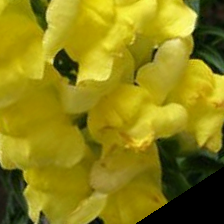

In [ ]:
train_data.display_sample(0)

In [ ]:
import torchvision.models as models
model = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# Freeze the parameters 
for param in model.parameters():
    param.requires_grad = False 

In [ ]:
from collections import OrderedDict

#Classifier architecture to put on top of resnet18
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,104)),
    #('relu', nn.ReLU()),
    #('fc2', nn.Linear(100,104)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc

model.to(default_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torch import nn
from torch import optim
from time import ctime
import matplotlib.pyplot as plt
from torchvision import transforms

#function to train the model
def train_validate(model, train_names, val_names, criterion, optimizer, epochs = 5, BATCH_SIZE=8,
                   t_transform=None, v_transform=None):
    print('Begin', ctime())
    for e in range(epochs):
      train_data = flowerDataSet(gcs_path=train_names, train = True, transform=t_transform)
      trainloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=False)
      train_loss =[]
      val_loss=[]
      running_loss=0
      batch_num=0
      for s in range(NUM_TRAINING_IMAGES//BATCH_SIZE):
        for images, labels in trainloader:
            inputs, labels = images.to(default_device), labels.to(default_device)
            batch_num+=1

            optimizer.zero_grad()
            img = model(inputs)
            loss = criterion(img, labels)
            running_loss+=loss.item()
            loss.backward()
            optimizer.step()
      train_loss.append(running_loss/NUM_TRAINING_IMAGES)
      print('Training Steps:', NUM_TRAINING_IMAGES//BATCH_SIZE, "Batches:", batch_num)
      running_loss=0
      batch_num=0
      val_data = flowerDataSet(gcs_path=val_names, train = True, transform=v_transform)
      val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle=False)
      for s in range(NUM_VALIDATION_IMAGES//BATCH_SIZE):
          for images, labels in val_loader:
            inputs, labels = images.to(default_device), labels.to(default_device)
            batch_num+=1

            img = model(inputs)
            loss = criterion(img, labels)
            running_loss+=loss.item()

      val_loss.append(running_loss/NUM_VALIDATION_IMAGES)
      print('Validation Steps:', NUM_VALIDATION_IMAGES//BATCH_SIZE, "Batches:", batch_num)
      print("Epoch : {}/{}..".format(e+1,epochs),
         "Training Loss:", train_loss[-1],
         "Validation Loss:", val_loss[-1], ctime()) 
      torch.save(model.state_dict(), '/content/gdrive/My Drive/flowers0822_e{:02d}.pth'.format(e))

    plt.plot(train_loss,label="Training Loss")
    plt.plot(val_loss,label="Validation Loss")
    plt.show() 
    
  

In [ ]:
epochs = 5
#optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.NLLLoss()
t_transform=transforms.Compose([
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=45, resample = Image.BICUBIC, expand = True),
                        transforms.RandomCrop((224,224)),
                        transforms.ToTensor()])
v_transform=transforms.Compose(
                    [
                        transforms.Resize((224,224)),
                        transforms.ToTensor()
                    ])

#train_validate(model,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, epochs,
#               t_transform=t_transform, v_transform=v_transform) 

In [ ]:
list(model.modules())

[ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [ ]:
import torch.nn.utils.prune as prune

def prune_network(model, proportion):
    for module in list(model.children()):
        if isinstance(module,nn.Conv2d) or isinstance(module, nn.Conv1d):
            # conv layer? -> Structured pruning of channels? or unstructured?
            # Below is prune based on l2 norm, by channel
            prune.ln_structured(module, name="weight", amount=proportion, n=2, dim=0)
            # For just unstructured pruning, uncomment the line below:
            #prune.l1_unstructured(module, "weight", proportion)
        elif isinstance(module,nn.Linear):
            # fc layer? -> prune all weights, unstructured
            prune.l1_unstructured(module, "weight", proportion)

PRUNING ITERATION  0 Prune proportion: 0.1 Sun Aug 23 10:20:24 2020
---------------------
PRUNING ITERATION  0 Sun Aug 23 10:20:24 2020
Begin Sun Aug 23 10:20:24 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23394182081139528 Validation Loss: 0.18275157917001894 Sun Aug 23 10:34:36 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.2105377683927057 Validation Loss: 0.17536686977837235 Sun Aug 23 10:45:13 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20112733456220644 Validation Loss: 0.17006172005344053 Sun Aug 23 10:55:50 2020


pruning network...
PRUNING ITERATION  1 Prune proportion: 0.19 Sun Aug 23 10:55:52 2020
---------------------
PRUNING ITERATION  1 Sun Aug 23 10:55:52 2020
Begin Sun Aug 23 10:55:52 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23092209321489 Validation Loss: 0.18267425668730947 Sun Aug 23 11:06:33 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.20924909616987966 Validation Loss: 0.17312881889640644 Sun Aug 23 11:17:09 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20109774282490292 Validation Loss: 0.1684672992198792 Sun Aug 23 11:27:32 2020


pruning network...
PRUNING ITERATION  2 Prune proportion: 0.271 Sun Aug 23 11:27:33 2020
---------------------
PRUNING ITERATION  2 Sun Aug 23 11:27:33 2020
Begin Sun Aug 23 11:27:33 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/4.. Training Loss: 0.2405528436382546 Validation Loss: 0.186005522942588 Sun Aug 23 11:37:55 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/4.. Training Loss: 0.2119409956553866 Validation Loss: 0.1792342469722418 Sun Aug 23 11:48:15 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/4.. Training Loss: 0.20126269227157412 Validation Loss: 0.17166797400869685 Sun Aug 23 11:58:32 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 4/4.. Training Loss: 0.1945839225626605 Validation Loss: 0.1690524776992067 Sun Aug 23 12:08:54 2020


pruning network...
PRUNING ITERATION  3 Prune proportion: 0.34390000000000004 Sun Aug 23 12:08:57 2020
---------------------
PRUNING ITERATION  3 Sun Aug 23 12:08:57 2020
Begin Sun Aug 23 12:08:57 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/4.. Training Loss: 0.25557419283337884 Validation Loss: 0.19102995186755112 Sun Aug 23 12:19:19 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/4.. Training Loss: 0.22073029824951382 Validation Loss: 0.18220630754186803 Sun Aug 23 12:29:35 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/4.. Training Loss: 0.20921844970307835 Validation Loss: 0.17727365469206766 Sun Aug 23 12:39:53 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 4/4.. Training Loss: 0.20131248397765641 Validation Loss: 0.1738025477629733 Sun Aug 23 12:50:19 2020


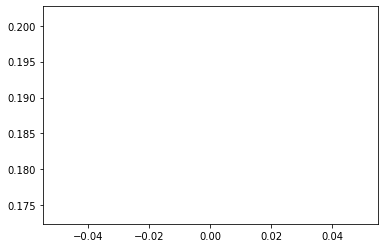

pruning network...
PRUNING ITERATION  4 Prune proportion: 0.40951000000000004 Sun Aug 23 12:50:19 2020
---------------------
PRUNING ITERATION  4 Sun Aug 23 12:50:19 2020
Begin Sun Aug 23 12:50:19 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/5.. Training Loss: 0.30627056000738023 Validation Loss: 0.21540239585788343 Sun Aug 23 13:00:39 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/5.. Training Loss: 0.24784342948711593 Validation Loss: 0.2000299322836358 Sun Aug 23 13:11:08 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/5.. Training Loss: 0.23079875700942845 Validation Loss: 0.18939575479076853 Sun Aug 23 13:21:31 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 4/5.. Training Loss: 0.21697070090586387 Validation Loss: 0.18467469414663984 Sun Aug 23 13:31:56 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch

In [ ]:
from torchvision import models
from collections import OrderedDict
from torch import optim

learning_rate=.0002

repetitions = 5
prune_proportion = 0.0
prune_change=lambda x:0.1+0.9*x #Keep 90% of the existing network
momentum = 0.5
network = models.resnet18(pretrained = True)

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,104)),
    #('relu', nn.ReLU()),
    #('fc2', nn.Linear(100,104)),
    ('output', nn.LogSoftmax(dim=1))
]))

network.fc = fc

network.to(default_device)

initial_state_dict = torch.load('/content/gdrive/My Drive/flowers0822_e04.pth')
#init the masks, etc. 
network.load_state_dict(initial_state_dict)

prune_network(network, 0.0)
#saved_val = initial_state_dict["conv1.weight_orig"].clone().detach()
# delete all the masks so that they are not loaded later
for k in initial_state_dict.copy():
    # detach the vars so they don't just change as the model trains
    initial_state_dict[k] = initial_state_dict[k].clone().detach()
    if "mask" in k:
        del initial_state_dict[k]


#torch.save(network.state_dict(), './pruning_examples/model.pth') # save the initial model + weights to the disk but also keep in memory



for rep in range(repetitions):
    prune_proportion=prune_change(prune_proportion)
    j_epochs=3+int(rep/2) #increase the number of epochs by 1 every other time
    #load the original weights w/o changing the pruning mask
    network.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

    print("PRUNING ITERATION ",rep, "Prune proportion:", prune_proportion, ctime())

    #load the original weights w/o changing the pruning mask
    network.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

    train_validate(network,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, j_epochs,
               t_transform=t_transform, v_transform=v_transform) 
    # train for J iterations
    # prune network
    if rep < repetitions-1: # if not the end of last round
        print("pruning network...")
        prune_network(network, prune_proportion)

    torch.save(network.state_dict(), '/content/gdrive/My Drive/flowers0823pruned3_{}.pth'.format(rep))

PRUNING ITERATION  5 Prune proportion: 0.46855900000000006 Sun Aug 23 14:34:21 2020
Begin Sun Aug 23 14:34:21 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/5.. Training Loss: 0.3353437517312408 Validation Loss: 0.25183508676830035 Sun Aug 23 14:44:43 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/5.. Training Loss: 0.28682680323686094 Validation Loss: 0.23355747523300094 Sun Aug 23 14:55:00 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/5.. Training Loss: 0.2663390560121356 Validation Loss: 0.22402668403108314 Sun Aug 23 15:05:27 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 4/5.. Training Loss: 0.2560597304212414 Validation Loss: 0.21276009886461342 Sun Aug 23 15:15:57 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 5/5.. Training Loss: 0.2461176400632192 Validation Loss: 0.2082933743628834 Sun Aug 23

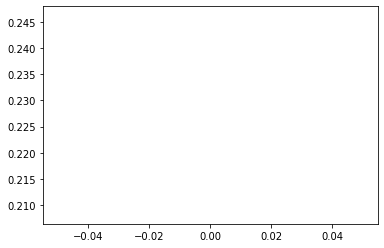

PRUNING ITERATION  6 Prune proportion: 0.5217031000000001 Sun Aug 23 15:26:36 2020
Begin Sun Aug 23 15:26:36 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/6.. Training Loss: 0.331330630738698 Validation Loss: 0.25105059538678876 Sun Aug 23 15:37:12 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/6.. Training Loss: 0.2810211479500267 Validation Loss: 0.2323510870658632 Sun Aug 23 15:47:42 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/6.. Training Loss: 0.26497975408465385 Validation Loss: 0.22285636225394134 Sun Aug 23 15:58:13 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 4/6.. Training Loss: 0.25327907305067404 Validation Loss: 0.21359643550461221 Sun Aug 23 16:08:40 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 5/6.. Training Loss: 0.24749439349503907 Validation Loss: 0.20646797745199552 Sun Aug 23

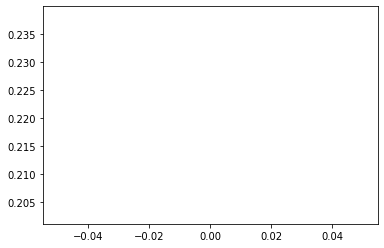

PRUNING ITERATION  7 Prune proportion: 0.5695327900000001 Sun Aug 23 16:29:56 2020
Begin Sun Aug 23 16:29:56 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/6.. Training Loss: 0.33338608537422837 Validation Loss: 0.2516397180132054 Sun Aug 23 16:40:38 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/6.. Training Loss: 0.28370978036675 Validation Loss: 0.2315195470984126 Sun Aug 23 16:51:16 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/6.. Training Loss: 0.2656417792847154 Validation Loss: 0.2223559955199217 Sun Aug 23 17:01:53 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 4/6.. Training Loss: 0.25240144574304735 Validation Loss: 0.2137135949772622 Sun Aug 23 17:12:24 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 5/6.. Training Loss: 0.24660883793305166 Validation Loss: 0.20792087930222525 Sun Aug 23 17:

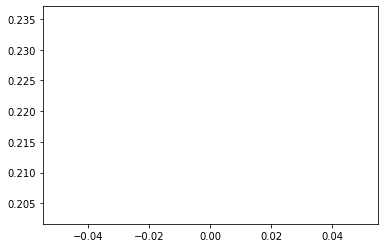

In [ ]:
for rep in range(repetitions,8):
    prune_proportion=prune_change(prune_proportion)
    j_epochs=3+int(rep/2) #increase the number of epochs by 1 every other time
    #load the original weights w/o changing the pruning mask
    network.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

    print("PRUNING ITERATION ",rep, "Prune proportion:", prune_proportion, ctime())

    #load the original weights w/o changing the pruning mask
    network.load_state_dict(initial_state_dict, strict=False)
    # re-make the optimizer to make sure it's tracking the weight tensors properly
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

    train_validate(network,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, j_epochs,
               t_transform=t_transform, v_transform=v_transform) 
    # train for J iterations
    # prune network
    if rep < repetitions-1: # if not the end of last round
        print("pruning network...")
        prune_network(network, prune_proportion)

In [ ]:
from torchvision import models
from collections import OrderedDict
from torch import optim

learning_rate=.0002

repetitions = 5
prune_proportion = 0.0
prune_change=lambda x:0.1+0.9*x #Keep 90% of the existing network
momentum = 0.5
network = models.resnet18(pretrained = True)

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,104)),
    #('relu', nn.ReLU()),
    #('fc2', nn.Linear(100,104)),
    ('output', nn.LogSoftmax(dim=1))
]))

network.fc = fc

network.to(default_device)

prune_network(network, 0.0)

initial_state_dict = torch.load('/content/gdrive/My Drive/flowers0823pruned3_{}.pth'.format(2))
#init the masks, etc. 
network.load_state_dict(initial_state_dict)

prune_network(network, 0.33)


learning_rate=0.01
for x in range(3):
  learning_rate/=2
  optimizer = optim.Adam(network.parameters(), lr=learning_rate)
  train_validate(network,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, 3,
               t_transform=t_transform, v_transform=v_transform)
  torch.save(network.state_dict(), '/content/gdrive/My Drive/flowers0823pruned_more2_{}.pth'.format(x))

Begin Mon Aug 24 17:53:57 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.4882160969493923 Validation Loss: 0.4348892679373766 Mon Aug 24 18:07:28 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.43254673047261283 Validation Loss: 0.40015712919934043 Mon Aug 24 18:19:13 2020


KeyboardInterrupt: ignored

Begin Mon Aug 24 18:24:55 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.47777738278027865 Validation Loss: 0.43517594816612787 Mon Aug 24 18:36:02 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.43471901379201416 Validation Loss: 0.4034765061504882 Mon Aug 24 18:47:01 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.41177893597257287 Validation Loss: 0.3828038798709368 Mon Aug 24 18:58:06 2020


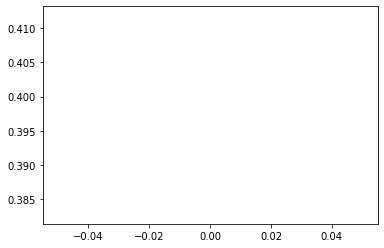

Begin Mon Aug 24 18:58:08 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.3856110451390283 Validation Loss: 0.3608678501934327 Mon Aug 24 19:08:58 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.3729651384257171 Validation Loss: 0.3523091444231827 Mon Aug 24 19:19:36 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.3649473483820649 Validation Loss: 0.3405925249680877 Mon Aug 24 19:30:01 2020


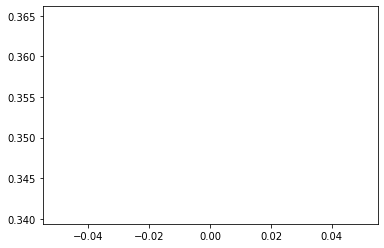

Begin Mon Aug 24 19:30:02 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.34716866233344545 Validation Loss: 0.32770518708074914 Mon Aug 24 19:40:28 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.3389917840436422 Validation Loss: 0.3227891208411291 Mon Aug 24 19:51:02 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.3323482411202941 Validation Loss: 0.31766970038157083 Mon Aug 24 20:01:31 2020


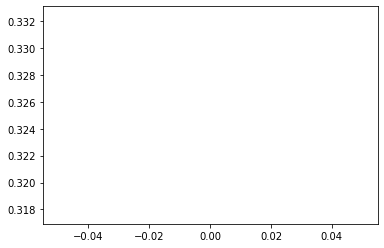

In [ ]:
learning_rate=0.01
for x in range(3):
  learning_rate/=2
  optimizer = optim.Adam(network.parameters(), lr=learning_rate)
  train_validate(network,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, 3,
               t_transform=t_transform, v_transform=v_transform)
  torch.save(network.state_dict(), '/content/gdrive/My Drive/flowers0823pruned_more2_{}.pth'.format(x))

Begin Mon Aug 24 20:05:30 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.32900935068398207 Validation Loss: 0.3160198956631638 Mon Aug 24 20:16:07 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.3226237550002775 Validation Loss: 0.3148335643144774 Mon Aug 24 20:26:38 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.3175798131654396 Validation Loss: 0.30820100293655334 Mon Aug 24 20:37:13 2020


Begin Mon Aug 24 20:37:14 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.3151120285581049 Validation Loss: 0.30579087936223065 Mon Aug 24 20:47:49 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.3123241634282151 Validation Loss: 0.3044845238006834 Mon Aug 24 20:58:17 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.3014213938409465 Validation Loss: 0.3045015053759361 Mon Aug 24 21:08:42 2020


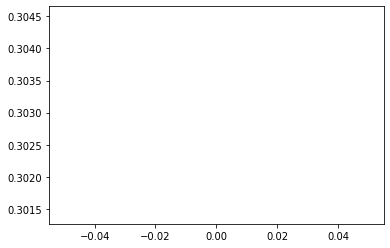

Begin Mon Aug 24 21:08:42 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.3025463573102398 Validation Loss: 0.30028570583090186 Mon Aug 24 21:19:04 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.29968854157511304 Validation Loss: 0.29800542177439765 Mon Aug 24 21:29:26 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.2943576697386041 Validation Loss: 0.30003807647153735 Mon Aug 24 21:39:51 2020


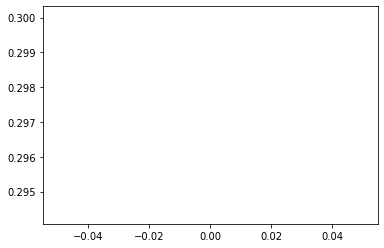

Begin Mon Aug 24 21:39:52 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.28974054079004186 Validation Loss: 0.29571906649025864 Mon Aug 24 21:50:21 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.2868527842906562 Validation Loss: 0.2947851150007597 Mon Aug 24 22:00:50 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.2837144082960854 Validation Loss: 0.29778566372034876 Mon Aug 24 22:11:25 2020


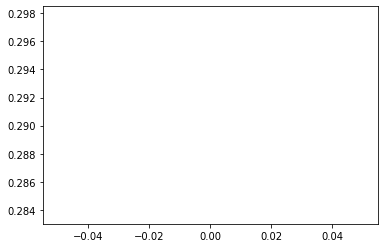

Begin Mon Aug 24 22:11:25 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.2824099355843977 Validation Loss: 0.29625047924767794 Mon Aug 24 22:22:02 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.2760618992467062 Validation Loss: 0.28882438911060837 Mon Aug 24 22:32:44 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.27457789403825966 Validation Loss: 0.29070630733822955 Mon Aug 24 22:43:30 2020


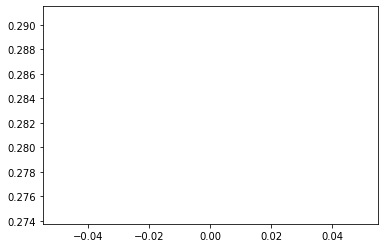

Begin Mon Aug 24 22:43:31 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.27326713257150764 Validation Loss: 0.2867587353102863 Mon Aug 24 22:54:14 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.26678646307669085 Validation Loss: 0.28543508789855343 Mon Aug 24 23:05:16 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.26462535395731057 Validation Loss: 0.2846303008464647 Mon Aug 24 23:16:13 2020


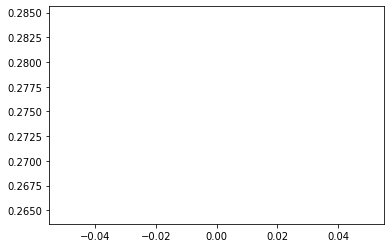

Begin Mon Aug 24 23:16:13 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.26200812283865677 Validation Loss: 0.29063030754633506 Mon Aug 24 23:26:59 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.26059571748657395 Validation Loss: 0.2849440138208969 Mon Aug 24 23:37:51 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.25944826845598157 Validation Loss: 0.28487852613987596 Mon Aug 24 23:48:37 2020


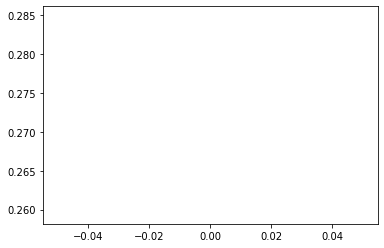

Begin Mon Aug 24 23:48:37 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.25410668284698795 Validation Loss: 0.28484856162284466 Mon Aug 24 23:59:23 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.2525967491974244 Validation Loss: 0.2843071331655414 Tue Aug 25 00:10:09 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.25184449438514833 Validation Loss: 0.2798414121157137 Tue Aug 25 00:21:11 2020


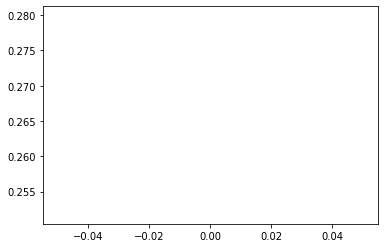

Begin Tue Aug 25 00:21:11 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.24844484318754378 Validation Loss: 0.28133729766604715 Tue Aug 25 00:32:21 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.24664412578264797 Validation Loss: 0.2861782553091902 Tue Aug 25 00:43:30 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.2429861050535256 Validation Loss: 0.2777493191112218 Tue Aug 25 00:54:33 2020


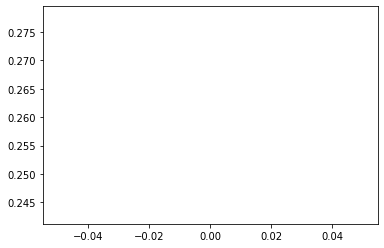

Begin Tue Aug 25 00:54:33 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23922785720263967 Validation Loss: 0.2808592781296064 Tue Aug 25 01:05:41 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.23853743965977417 Validation Loss: 0.2825193565724225 Tue Aug 25 01:16:50 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.23748627731746424 Validation Loss: 0.2831601697534066 Tue Aug 25 01:27:59 2020


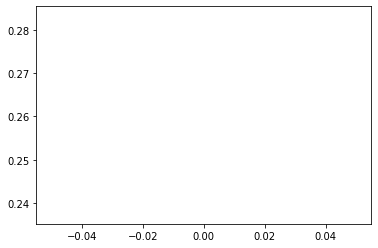

Begin Tue Aug 25 01:27:59 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.23448513265143262 Validation Loss: 0.28597228415310383 Tue Aug 25 01:39:11 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.2339245413066284 Validation Loss: 0.27895141346380115 Tue Aug 25 01:50:22 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.23055724203609948 Validation Loss: 0.2716418334347164 Tue Aug 25 02:01:30 2020


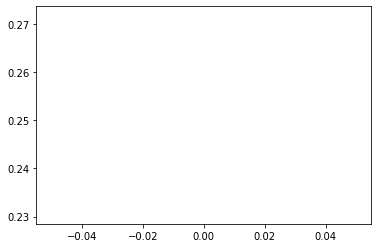

Begin Tue Aug 25 02:01:31 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.22929045157199615 Validation Loss: 0.27948139286760626 Tue Aug 25 02:12:41 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.22600990540839397 Validation Loss: 0.27650603256991196 Tue Aug 25 02:23:53 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.22291578614299534 Validation Loss: 0.2786742421348804 Tue Aug 25 02:35:09 2020


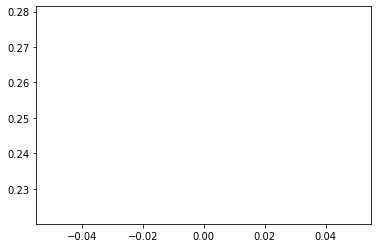

Begin Tue Aug 25 02:35:10 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.22148646252333656 Validation Loss: 0.27842137670337125 Tue Aug 25 02:46:14 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.22090213604976566 Validation Loss: 0.2775626904010002 Tue Aug 25 02:57:28 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.2194295912866526 Validation Loss: 0.27529621037558233 Tue Aug 25 03:08:36 2020


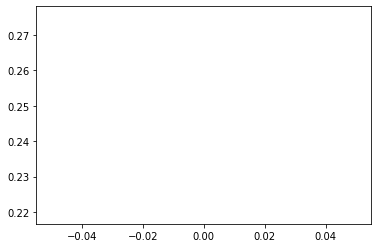

Begin Tue Aug 25 03:08:37 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.2181833227068866 Validation Loss: 0.2784824795089662 Tue Aug 25 03:19:47 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21518187124028276 Validation Loss: 0.2762460917523452 Tue Aug 25 03:30:54 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.21122201338689636 Validation Loss: 0.2761519822404431 Tue Aug 25 03:41:57 2020


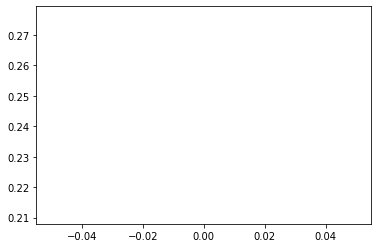

Begin Tue Aug 25 03:41:57 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.21497802613137293 Validation Loss: 0.2726744840660229 Tue Aug 25 03:53:01 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.21226548377386797 Validation Loss: 0.2788087599107931 Tue Aug 25 04:04:10 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20871108932550456 Validation Loss: 0.269702671834364 Tue Aug 25 04:15:31 2020


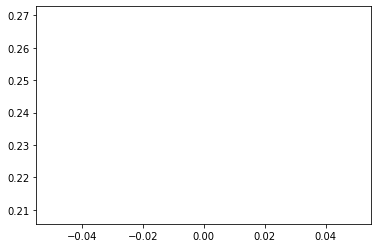

Begin Tue Aug 25 04:15:31 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.20713868309570407 Validation Loss: 0.27241106665339965 Tue Aug 25 04:27:18 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.20458659346707705 Validation Loss: 0.28063824019748074 Tue Aug 25 04:39:13 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.20228577763868072 Validation Loss: 0.27854862878227543 Tue Aug 25 04:51:20 2020


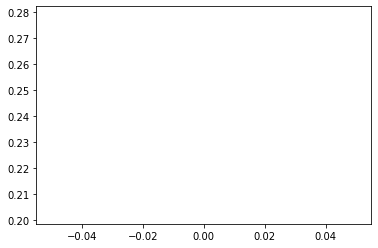

Begin Tue Aug 25 04:51:20 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.2040294329016889 Validation Loss: 0.2732377434309957 Tue Aug 25 05:03:25 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.19948627129121171 Validation Loss: 0.2752112912431616 Tue Aug 25 05:15:16 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.1987892669116358 Validation Loss: 0.2812501835829482 Tue Aug 25 05:26:39 2020


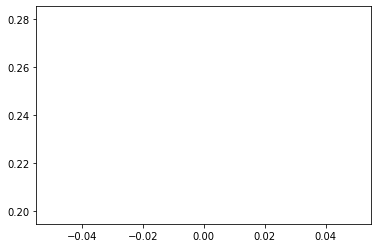

Begin Tue Aug 25 05:26:40 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.19728006931493713 Validation Loss: 0.2731152440357054 Tue Aug 25 05:37:47 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.19663962219043365 Validation Loss: 0.27195108315811073 Tue Aug 25 05:48:42 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.19742506760705136 Validation Loss: 0.2785761664814219 Tue Aug 25 05:59:29 2020


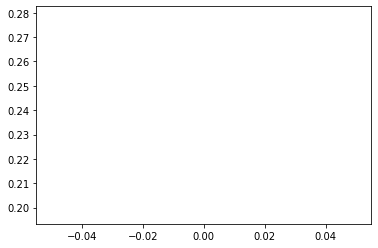

Begin Tue Aug 25 05:59:30 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.19205806080284357 Validation Loss: 0.28087334661616076 Tue Aug 25 06:10:18 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.18946356686046992 Validation Loss: 0.27928488686327535 Tue Aug 25 06:21:05 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.1889704022313215 Validation Loss: 0.28262738743796945 Tue Aug 25 06:31:54 2020


Begin Tue Aug 25 06:31:55 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.19182209428559002 Validation Loss: 0.2798460543653446 Tue Aug 25 06:42:42 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.1871247990060524 Validation Loss: 0.2839849914006632 Tue Aug 25 06:53:45 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.18678862893220574 Validation Loss: 0.2768822221310231 Tue Aug 25 07:04:58 2020


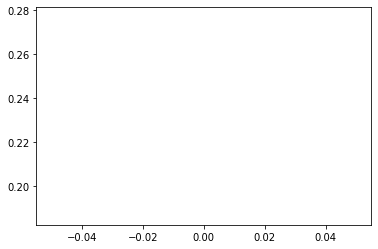

Begin Tue Aug 25 07:04:58 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.18570978233559612 Validation Loss: 0.2833049211426285 Tue Aug 25 07:16:26 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.18209365770567784 Validation Loss: 0.28139494741656657 Tue Aug 25 07:28:00 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.18163306377831043 Validation Loss: 0.2894954542822108 Tue Aug 25 07:39:28 2020


Begin Tue Aug 25 07:39:29 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.18082507437354003 Validation Loss: 0.289940040751264 Tue Aug 25 07:51:14 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.18112550758010573 Validation Loss: 0.27695994531928464 Tue Aug 25 08:02:46 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.17679223083243 Validation Loss: 0.28146055104724804 Tue Aug 25 08:14:22 2020


Begin Tue Aug 25 08:14:22 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.17766116798685866 Validation Loss: 0.28309219312886225 Tue Aug 25 08:25:57 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.1764972289343689 Validation Loss: 0.2851196390673004 Tue Aug 25 08:37:18 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.17439282508090104 Validation Loss: 0.2874967038053377 Tue Aug 25 08:48:23 2020


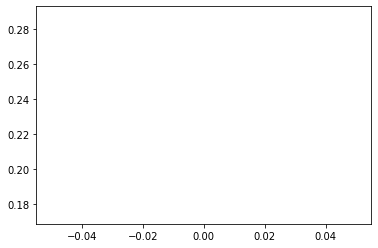

Begin Tue Aug 25 08:48:23 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.17556573304626732 Validation Loss: 0.28690008823920427 Tue Aug 25 08:59:10 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.16925596750353697 Validation Loss: 0.2848900004996565 Tue Aug 25 09:09:56 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.17256068208750805 Validation Loss: 0.28871403731694767 Tue Aug 25 09:20:45 2020


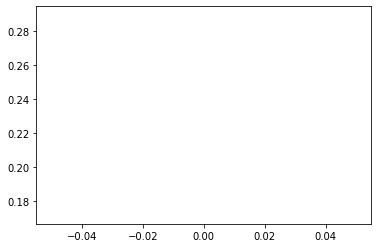

Begin Tue Aug 25 09:20:46 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.1717605071563978 Validation Loss: 0.2825276774980513 Tue Aug 25 09:31:34 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.1680208235630884 Validation Loss: 0.2815055758692324 Tue Aug 25 09:42:27 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.17017634569229187 Validation Loss: 0.28312032421697575 Tue Aug 25 09:53:21 2020


Begin Tue Aug 25 09:53:21 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.1684382932022124 Validation Loss: 0.2898979183318543 Tue Aug 25 10:04:21 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.16544919815517675 Validation Loss: 0.2817557111607286 Tue Aug 25 10:15:17 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.1652040982292202 Validation Loss: 0.29523851985818356 Tue Aug 25 10:26:15 2020


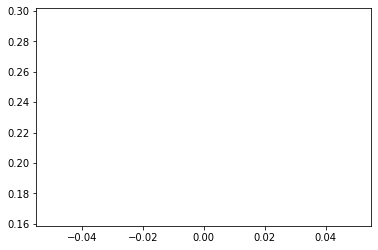

Begin Tue Aug 25 10:26:15 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.16483653304689605 Validation Loss: 0.2911269302030319 Tue Aug 25 10:37:28 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.16137374046712935 Validation Loss: 0.2869664776010503 Tue Aug 25 10:48:58 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.16307575775648223 Validation Loss: 0.2860600038206783 Tue Aug 25 11:00:18 2020


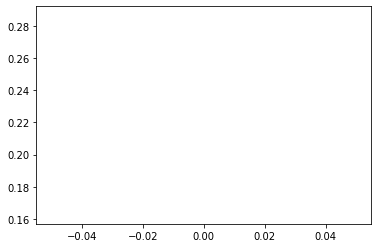

Begin Tue Aug 25 11:00:18 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.15914290502233935 Validation Loss: 0.29314471317198254 Tue Aug 25 11:11:40 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 2/3.. Training Loss: 0.15770487737363062 Validation Loss: 0.29065772064897266 Tue Aug 25 11:22:56 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 3/3.. Training Loss: 0.1598544430122332 Validation Loss: 0.2930149830123088 Tue Aug 25 11:34:03 2020


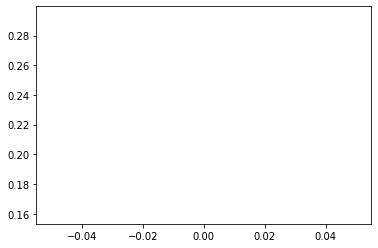

Begin Tue Aug 25 11:34:04 2020
Training Steps: 1594 Batches: 1594
Validation Steps: 464 Batches: 464
Epoch : 1/3.. Training Loss: 0.15674405033802188 Validation Loss: 0.2884849898661647 Tue Aug 25 11:45:15 2020


KeyboardInterrupt: ignored

In [ ]:
for x in range(3,20):
  optimizer = optim.Adam(network.parameters(), lr=learning_rate)
  train_validate(network,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, 3,
               t_transform=t_transform, v_transform=v_transform)
  torch.save(network.state_dict(), '/content/gdrive/My Drive/flowers0823pruned_more2_{}.pth'.format(x))
  train_validate(network,TRAINING_FILENAMES, VALIDATION_FILENAMES, criterion, optimizer, 3,
               t_transform=t_transform, v_transform=v_transform)

In [ ]:
#To generate the test results:
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition
test_data = flowerDataSet(gcs_path=TEST_FILENAMES, train = False, transform=v_transform)
testloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=False)

b'252d840db'


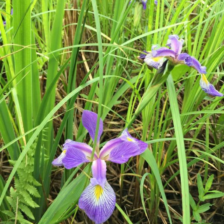

In [ ]:
test_data.display_sample(0)

In [ ]:
pred_list=[]
label_list=[]
batch_num=0
print('Begin', ctime())
for step in range(7382//BATCH_SIZE):
  for images, labels in testloader:
    inputs, labels = images.to(default_device), labels
    batch_num+=1
    label_list+=[lbl.decode('utf-8') for lbl in labels]
    pred_list+=[c.item() for c in network.forward(inputs).max(dim=1).indices]
  if step%100==99:
    print(step, batch_num, ctime())

print(label_list)
print(pred_list)

Begin Sun Aug 23 19:36:37 2020
['d92df455f', '280b71230', '8fc79c991', '3aa210981', 'dd33bfef9', '69e5888fb', '9090142e8', 'd7c938976', '143b75258', '6ef97d18a', '7abf68943', 'bdf131dae', '52378ff5a', 'c9a7eae13', 'e2567b48c', '17118cb89', '25f594d35', 'c0e0640c6', '34302ff94', 'a16eb5fa0', 'aad6bc2bb', '8d4368f5c', 'e469820b2', 'd81fb8241', '0d4b7df42', 'f8b20dc7f', 'eab53f47e', '6ad636b14', '97a476deb', '61486eb05', '329581d4d', 'b87e16bc0', 'd8437a7f7', '981396649', '85c2ca274', 'f7019798c', 'b738a5ab0', '931b0b249', 'd35565c6c', '6fc119103', '7725cb554', 'f0727012b', '7b53e5791', 'ce5af8fc3', 'aaab6a867', 'dd9cf65da', '13d3c108e', '34cc8d691', 'e93da9242', '46241640f', 'c77e635e6', '0befbdd9e', 'b05b5e5ed', '7484473e0', 'cffa6d1a4', 'b811b25c9', 'bb15fd515', 'ce1019f58', 'cc0e98f9c', 'd83d3fbab', '1691d45e6', '026d4082b', '4fdd76274', 'a2fcedaf7', '62e32ec91', 'ed8c3c3f8', '7dc69b4eb', 'b7c137651', 'c4d436848', '07ccfbc89', 'a0c7302d1', '1eba038ad', 'a7caedcb0', '92673a9aa', '8128b

In [ ]:
import pandas as pd
pred_df=pd.DataFrame(zip(label_list,pred_list), columns=['id', 'label'])
print(pred_df.head())

          id  label
0  d92df455f    102
1  280b71230     49
2  8fc79c991     49
3  3aa210981     25
4  dd33bfef9    103


In [ ]:
pred_df.to_csv('flower_preds.csv', index=False)

In [ ]:
batch_num=0
label_list=[]
pred_list=[]
val_data = flowerDataSet(gcs_path=VALIDATION_FILENAMES, train = True, transform=v_transform)
val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle=False)
print('Begin', ctime())
for s in range(NUM_VALIDATION_IMAGES//BATCH_SIZE):
  for images, labels in val_loader:
    inputs, labels = images.to(default_device), labels.to(default_device)
    batch_num+=1
    label_list+=[lbl.item() for lbl in labels]
    pred_list+=[c.item() for c in network.forward(inputs).max(dim=1).indices]
  if s%100==99:
    print(s, batch_num, ctime())
print(len([x for x in range(NUM_VALIDATION_IMAGES) if label_list[x]==pred_list[x]]),
      'accurate of',NUM_VALIDATION_IMAGES, ctime())

Begin Mon Aug 24 08:40:18 2020
99 100 Mon Aug 24 08:40:35 2020
199 200 Mon Aug 24 08:40:53 2020
1930 accurate of 3712 Mon Aug 24 08:40:58 2020


In [ ]:
pred_list[:5], label_list[:5]

([102, 49, 49, 25, 103],
 ['d92df455f', '280b71230', '8fc79c991', '3aa210981', 'dd33bfef9'])

In [ ]:
from numpy import random

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        scores = model(img) # shape [1,1000]
        
        # score = scores[:,target_y] - l2_reg * torch.norm(img)
        score = scores.squeeze()[target_y] - l2_reg * torch.norm(img)
        
        score.backward()
      
        # img.data += learning_rate * img.grad.data / torch.norm(img.grad.data)
        # img.grad.data.zero_()
        with torch.no_grad():
            img += learning_rate * img.grad / torch.norm(img.grad)
            img.grad.zero_()

        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()).convert('RGB'))
            class_name = CLASSES[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        transforms.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        transforms.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

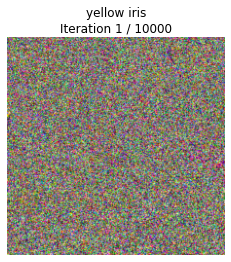

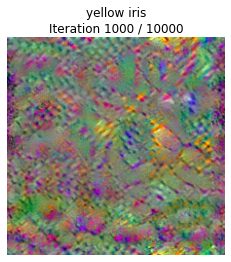

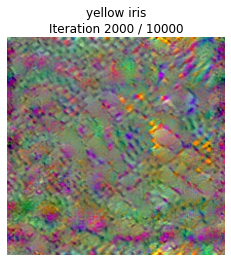

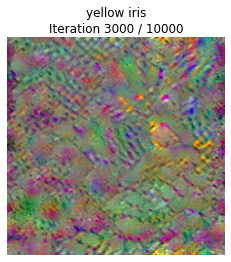

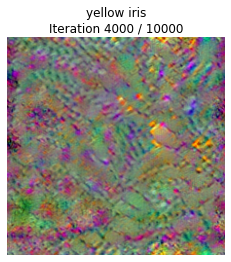

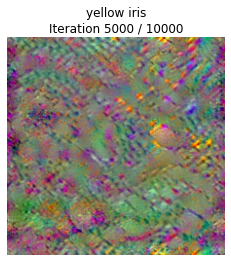

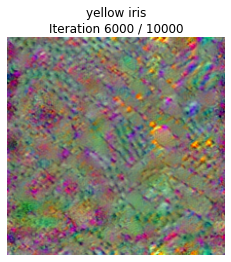

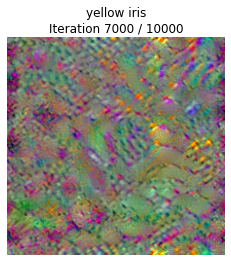

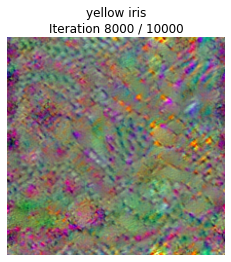

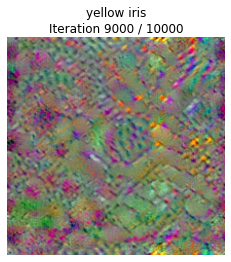

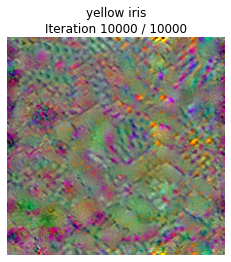

In [ ]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
network.type(dtype)

target_y = 14 
out = create_class_visualization(target_y, network, dtype, num_iterations=10000, show_every=1000)

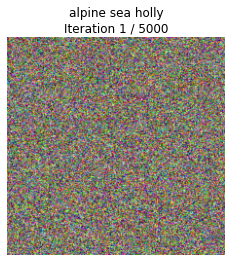

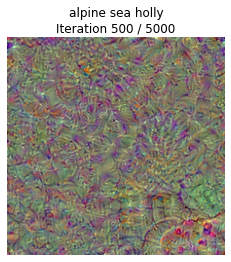

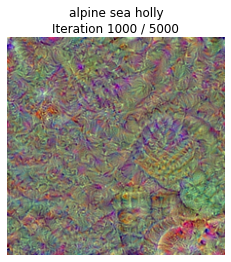

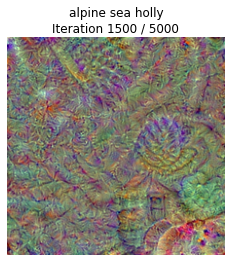

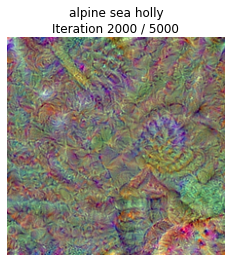

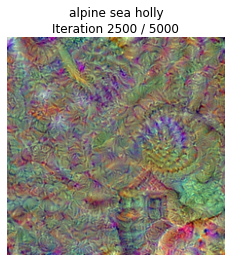

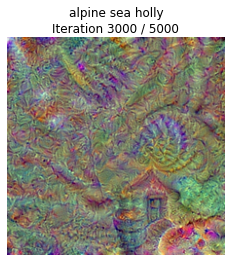

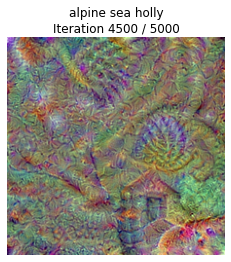

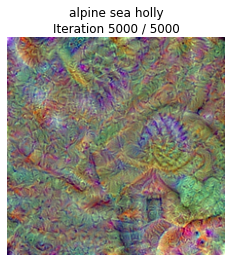

In [ ]:
target_y = 34 
out = create_class_visualization(target_y, network, dtype, num_iterations=5000, show_every=500)

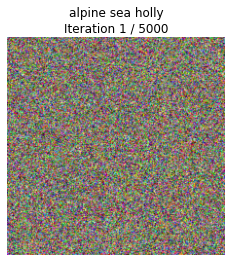

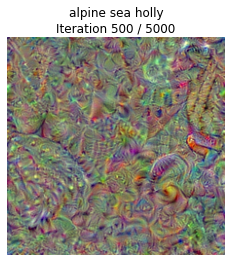

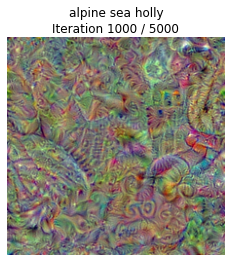

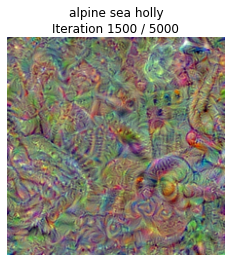

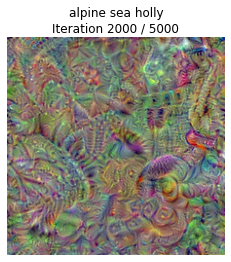

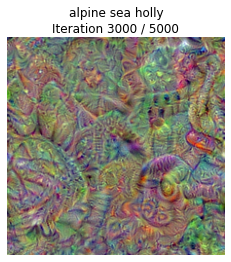

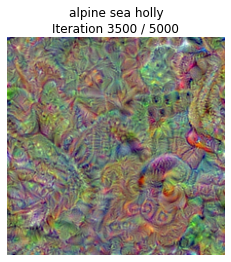

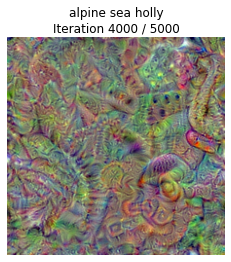

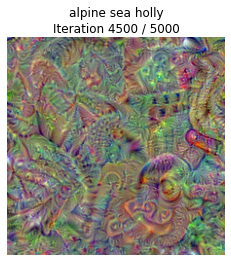

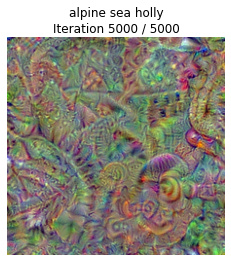

In [ ]:
network2 = models.resnet18(pretrained = True)

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,104)),
    #('relu', nn.ReLU()),
    #('fc2', nn.Linear(100,104)),
    ('output', nn.LogSoftmax(dim=1))
]))

network2.fc = fc

network2.to(default_device)
initial_state_dict = torch.load('/content/gdrive/My Drive/flowers0822_e{:02d}.pth'.format(5))
#init the masks, etc. 
network2.load_state_dict(initial_state_dict)

target_y = 34 
out = create_class_visualization(target_y, network2, dtype, num_iterations=5000, show_every=500)

In [ ]:
'''
val_loader = DataLoader(flower_val, batch_size = BATCH_SIZE, shuffle=False)
for s in range(NUM_VALIDATION_IMAGES//BATCH_SIZE):
    for images, labels in val_loader:
      inputs, labels = images.to(default_device), labels.to(default_device)
      inputs=inputs.permute(0,3,1,2)

      img = model(inputs)
      loss = criterion(img, labels)
      print(loss.item())
'''

In [ ]:
'''
flower_val = flowerDataSet(gcs_path=VALIDATION_FILENAMES, train = True)
flower_val_loader = DataLoader(flower_val, batch_size = 16, shuffle=False)
'''

In [ ]:
'''
def validate(model, trainloader, criterion, steps = 5):
    val_loss =[]
    for s in range(steps):
        running_loss =0
        for images, labels in trainloader:
            inputs, labels = images.to(default_device), labels.to(default_device)
            inputs=inputs.permute(0,3,1,2)

            optimizer.zero_grad()
            img = model(inputs)
            print(inputs.dtype, labels.dtype, img.dtype)
            print(inputs.shape, labels.shape, img.shape)

            loss = criterion(img, labels)
            running_loss+=loss
        print("Epoch : {}/{}..".format(s+1,steps),
         "Training Loss: {:.6f}".format(running_loss/len(trainloader))) 
        val_loss.append(running_loss)
    plt.plot(val_loss,label="Training Loss")
    plt.show() 
    '''